## Predict price at next period with simply deep FeedForward NN as a regression
#### we can also do is as a classification, for example look for an extrean events like if tomorrow is >20% grow etc


In [206]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


tf.__version__

# https://mapr.com/blog/deep-learning-tensorflow/


'1.5.0'

## connect to DB

In [207]:
DATABASE = 'prodcopy'

if DATABASE == 'prod':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-primary-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }
    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'stage':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'intelligenttrading-aurora-production-postgres-cluster.cluster-caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '5432',
      'dbname': 'primary_postgres'
    }

    try:
      db_connection = pg.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)
        
elif DATABASE == 'prodcopy':
    config = {
      'user': 'alienbaby',
      'password': 'alienbabymoonangel',
      'host': 'prodclone.caexel1tmds5.us-east-1.rds.amazonaws.com',
      'port': '3306',
      'database': 'intelligenttrading_primary',
      'raise_on_warnings': True,
    }

    try:
      db_connection = mysql.connector.connect(**config)
    except mysql.connector.Error as err:
      if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
      elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
      else:
        print(err)

## Get timeseries from Staging DB (both minute and hours)


In [208]:
transaction_coin = 'ETH'
counter_coin = 0

resample_period = 60

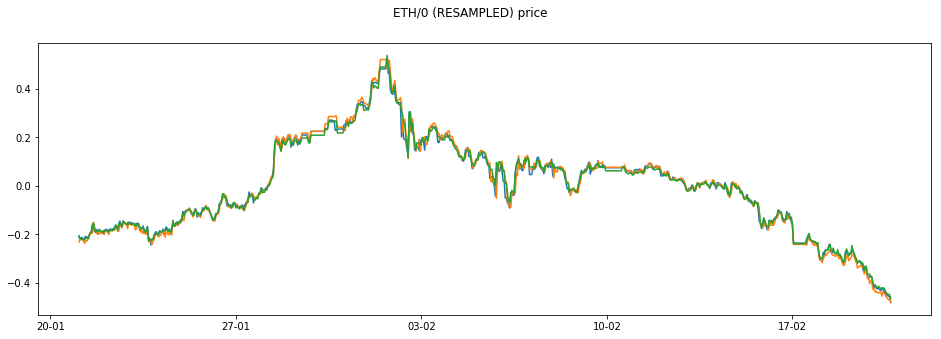

In [3]:


query = (" SELECT * FROM indicator_priceresampl WHERE \
transaction_currency='%s' AND \
counter_currency=%d \
and resample_period=%d " ) % (transaction_coin, counter_coin, resample_period)

resampl_df = pd.read_sql(query, con=db_connection)
resampl_df['timestamp'] = pd.to_datetime(resampl_df['timestamp'], unit='s')
resampl_df.index = pd.DatetimeIndex(resampl_df.timestamp)
resampl_df.sort_index(inplace=True)

# correct bad resampling
str(int(resample_period/60)) + 'H'
rule = str(int(resample_period/60)) + 'H'
res_df = resampl_df[['high_price','low_price','open_price','close_price']].resample(rule=rule).mean().bfill()

# extract closing price
ts = res_df[['open_price','close_price','high_price']]

# normalize
resampl_ts = (ts - ts.mean()) / (ts.max() - ts.min())

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("%s/%d (RESAMPLED) price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(resampl_ts)
plt.show()


In [216]:
query = "SELECT * FROM indicator_price WHERE transaction_currency='%s' AND counter_currency=%d "
query = query % (transaction_coin, counter_coin)
df_sql = pd.read_sql(query, con=db_connection)
df_sql['timestamp'] = pd.to_datetime(df_sql['timestamp'], unit='s')
df_sql.index = pd.DatetimeIndex(df_sql.timestamp)

raw_price_ts = df_sql["price"].to_frame()



In [223]:
price_ts = raw_price_ts  # remove gaps
price_ts[pd.isnull(price_ts["price"])] = None

# resample (for smoothing) and normalize (for learning)
price_ts = price_ts.resample(rule='30min').mean()

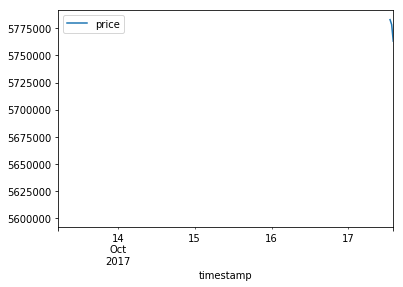

In [229]:
cutoff=210
price_ts.head(cutoff).plot()

In [257]:


# cut empty ts from the beginning
price_ts = price_ts.tail(len(price_ts)-cutoff)
price_ts = price_ts.interpolate() #fillna(method='ffill')

# normalize to 0 - 1
price_ts =  ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )
price_ts = price_ts + abs(price_ts.min(axis=0))


In [231]:
price_ts.min(axis=0)

price   -0.168804
dtype: float64

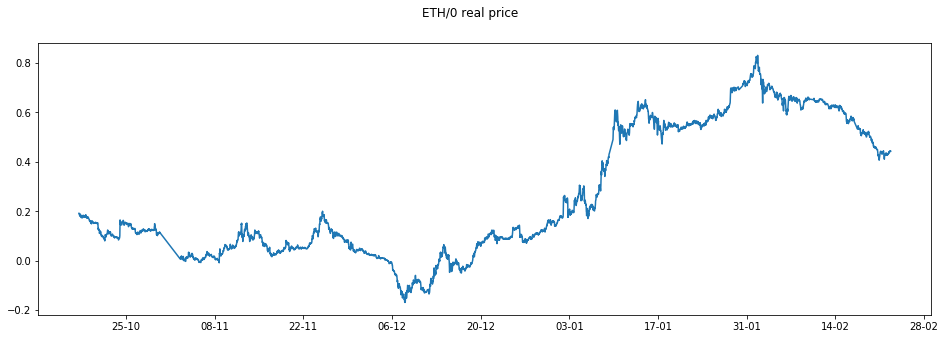

In [232]:


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.suptitle("%s/%d real price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(price_ts)
plt.show()

In [233]:
#print(resampl_ts.shape)
print(price_ts.shape)

(6151, 1)


## Helper functions to convert ts into dataset

In [234]:

# REGRESSION: dataset for regression: split one continues timeseries inro many subsets by striding
def regression_dataset_from_ts(data_df, win_size, stride):
    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    
    data_set = np.zeros([win_size,num_examples])
    labels = np.zeros([1,num_examples])

    for ex in range(0,num_examples):
        one_example = data_df[ex:ex+win_size]['price'].values.reshape([-1,1])
        #print(one_example.shape)
        label = data_df[ex+win_size:ex+win_size+1]['price'].values.reshape([-1,1])
        #print(label.shape)
        
        data_set[:,ex] = one_example[:,0]
        #print(data_set.shape)
        labels[:,ex] = label
    return data_set, labels


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) /  predictions.shape[0])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 


# REGRESSION

## Create a dataset by converting ts into matrix (X,Y)

In [248]:
train_num = int(len(price_ts) * 0.8)
test_num = len(price_ts) - train_num
             
ts_train = price_ts.head(train_num)
ts_test = price_ts.tail(test_num)

win_size = 96

# convert linear ts to number of training examples
X_train, Y_train = regression_dataset_from_ts(data_df=ts_train, win_size=win_size, stride=1)
X_test, Y_test = regression_dataset_from_ts(data_df=ts_test, win_size=win_size, stride=1)



n_features = X_train.shape[0]
classes = Y_train.shape[0]
m_test = X_test.shape[1]
m_train = X_train.shape[1]


In [249]:
X_train = X_train.astype(dtype=np.float32).T
Y_train = Y_train.T
X_test = X_test.astype(dtype=np.float32).T
Y_test = Y_test.T

print(X_train.shape)
print(Y_train.shape)
print("Y train first  = ")
print( str(Y_train[0:3,]))

print(X_test.shape)
print(Y_test.shape)

print(" m_train %d, m_test %d, n_features %d, classes %d" % (m_train, m_test,n_features,classes ))
  

(4824, 96)
(4824, 1)
Y train first  = 
[[0.15875321]
 [0.16148784]
 [0.15847217]]
(1231, 96)
(1231, 1)
 m_train 4824, m_test 1231, n_features 96, classes 1


In [250]:
m_train

4824

# Create Graph

In [252]:
batch_size = m_train-1  # make it regular batch GD
layer_dims = [n_features, 100, 200, 60, 30, 1]

graph_r = tf.Graph()
with graph_r.as_default():

    def initialize_parameters_deep(layer_dims):
        """
        parameters = initialize_parameters_deep([5,4,3])
        Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network

        Returns:
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                        bl -- bias vector of shape (layer_dims[l], 1)
        """

        np.random.seed(9)
        parameters = {}
        L = len(layer_dims)  # number of layers in the network

        for l in range(1, L):
            parameters['W' + str(l)] = tf.Variable(tf.truncated_normal([ layer_dims[l-1], layer_dims[l] ])) * 0.01
            parameters['b' + str(l)] = tf.Variable(tf.zeros( [1, layer_dims[l]] )) 
            
            # W matrix [prev_output, current hudden]
            assert ((parameters['W' + str(l)]).shape == (layer_dims[l - 1], layer_dims[l]))
            assert ((parameters['b' + str(l)]).shape == (1, layer_dims[l]))

        return parameters

    def nn_model(X, parameters):
        global glob_W3
        L = len(layer_dims)
        A = X

        for l in range(1, L-1):
            #print(l)
            A_prev = A
            #print(A)
            W = parameters['W' + str(l)]
            b = parameters['b' + str(l)]
            #print(W)
            A = tf.matmul(A_prev, W) + b
            A = tf.nn.relu(A)


        # add Sigmoid to the last layer
        l += 1
        #print("last layer:" + str(l))
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        out_layer = tf.matmul(A, W) + b
        #out_layer = tf.sigmoid(out_layer)
        glob_W3 = W

        return out_layer

    def regularization_term(alpha, par):
        #term = alpha * (tf.nn.l2_loss(nn_weights['h1']) + tf.nn.l2_loss(nn_biases['b1'])) + \
        #    alpha * (tf.nn.l2_loss(nn_weights['out']) + tf.nn.l2_loss(nn_biases['out']))
        #return term
        return 0

    ############  MODEL DEFINITION  ##################################
    # define tensors (matrix)
    tf_train_X = tf.placeholder(tf.float32, shape=(batch_size, n_features ))
    tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, classes))

    
    tf_predict_X = tf.placeholder(tf.float32, shape=(None, n_features ))  # m_test
    
    parameters = initialize_parameters_deep(layer_dims)
    
    nn_output_layer = nn_model(tf_train_X, parameters)

    # Optimization
    alpha = 0.001  # regularization term
    

    sq_error = tf.losses.mean_squared_error(labels=tf_train_y, predictions=nn_output_layer)
    loss = tf.reduce_mean(sq_error)
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    train_prediction = nn_output_layer

    #test_output = nn_model(tf_test_dataset, parameters)
    #test_prediction = test_output

    predict = nn_model(tf_predict_X, parameters)
        


In [253]:
X_train[:, 0:(0 + batch_size)].shape
X_train.shape

(4824, 96)

## Run the graph and train net

In [255]:

num_steps = 2200
#m_train = X_train.shape[0]

print_loss = []
print_accuracy = []
batch_prediction = []

with tf.Session(graph=graph_r) as session:
    tf.initialize_all_variables().run()
    print("Initialized")

    for step in range(num_steps):
        offset = (step * batch_size) % (m_train - batch_size)
        #print(offset)
        batch_data = X_train[offset:(offset + batch_size), :]
        #print("batch data=" + str(batch_data.shape))
        
        batch_labels = Y_train[offset:(offset + batch_size), :]
        #print("batch labels=" + str(batch_labels.shape))

        feed_dict = {tf_train_X: batch_data, tf_train_y: batch_labels}

        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        print_loss.append(l)
        print_accuracy.append(accuracy(predictions, batch_labels))
        
        if (step % 500 == 0):
            batch_prediction.append([predictions[0,:],batch_labels[0,:]])
            print("Minibatch loss at step %d: %f" % (step, l))
            #print("- Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)) 
            print("- Minibatch r2 score: %.1f%%" % r2_score(batch_labels, predictions, multioutput='variance_weighted'))

    print("\n")
    #print("Overall Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))    
    
    y_predicted_train = session.run(predict, feed_dict={tf_predict_X: X_train})
    y_predicted_test = session.run(predict, feed_dict={tf_predict_X: X_test})
    

    


Initialized
Minibatch loss at step 0: 0.070248
- Minibatch r2 score: -0.6%
Minibatch loss at step 500: 0.042808
- Minibatch r2 score: 0.0%
Minibatch loss at step 1000: 0.042133
- Minibatch r2 score: 0.0%
Minibatch loss at step 1500: 0.001219
- Minibatch r2 score: 1.0%
Minibatch loss at step 2000: 0.000920
- Minibatch r2 score: 1.0%




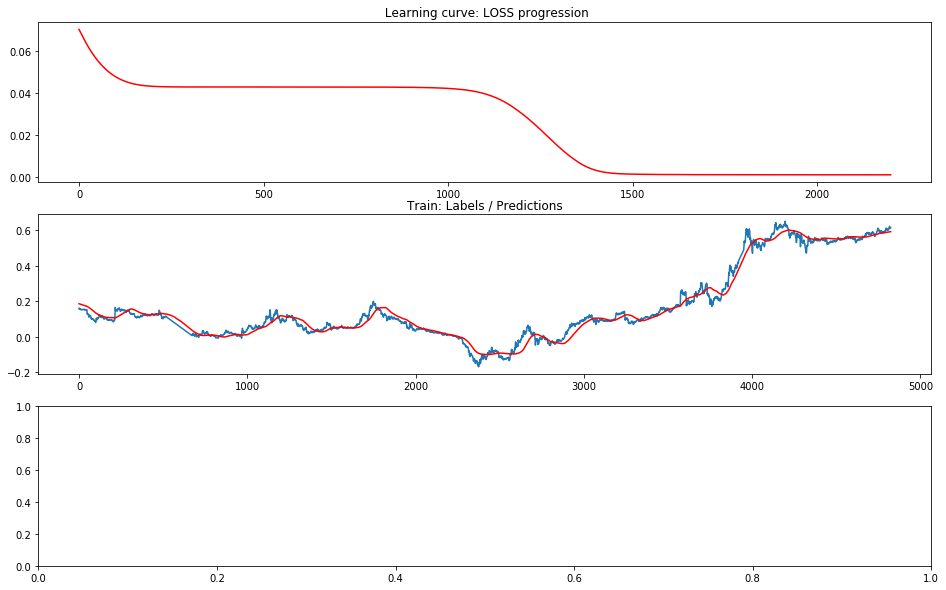

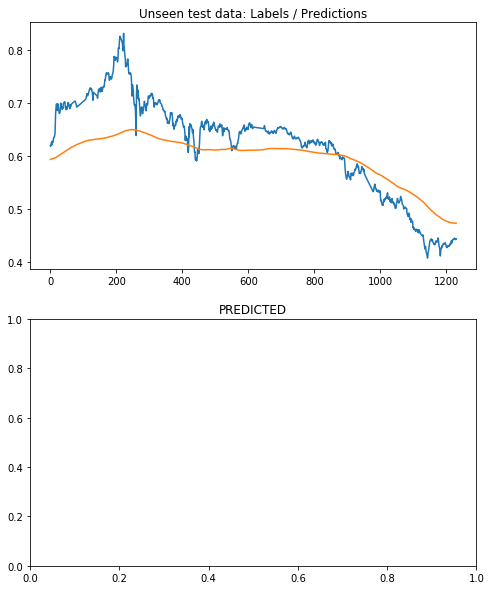

In [256]:

fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1, figsize=(16,10))
ax1.set_title(" Learning curve: LOSS progression")
ax1.plot(print_loss, color="red")
ax2.set_title("Train: Labels / Predictions")    
ax2.plot(Y_train)
ax2.plot(y_predicted_train, color="red")
plt.show()


fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(8,10))
ax1.set_title("Unseen test data: Labels / Predictions")
ax1.plot(Y_test)
ax2.set_title("PREDICTED")
ax1.plot(y_predicted_test)
plt.show()